Installing the Required Libraries

In [1]:
!pip install torch
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import random

Load data

In [3]:

data = pd.read_csv('emnist-digits-train.csv', header=None)
data.columns = ['label'] + [f'pixel{i}' for i in range(data.shape[1] - 1)]

C:\Users\91918\AppData\Local\Temp\ipykernel_26968\643361011.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['label'], palette='viridis')


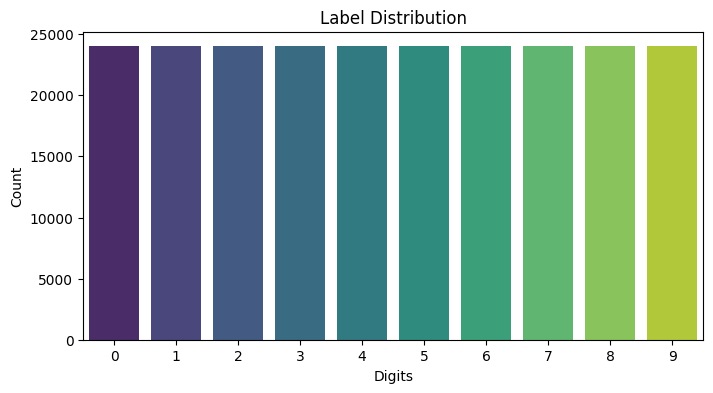

In [4]:

plt.figure(figsize=(8, 4))
sns.countplot(x=data['label'], palette='viridis')
plt.title("Label Distribution")
plt.xlabel("Digits")
plt.ylabel("Count")
plt.show()

Visualize some sample images from the dataset

In [5]:

def visualize_samples(data, num_samples=10):
    plt.figure(figsize=(15, 5))
    sample_indices = random.sample(range(len(data)), num_samples)
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(data.iloc[idx, 1:].values.reshape(28, 28), cmap='gray')
        plt.title(f"Label: {data.iloc[idx, 0]}")
        plt.axis('off')
    plt.show()

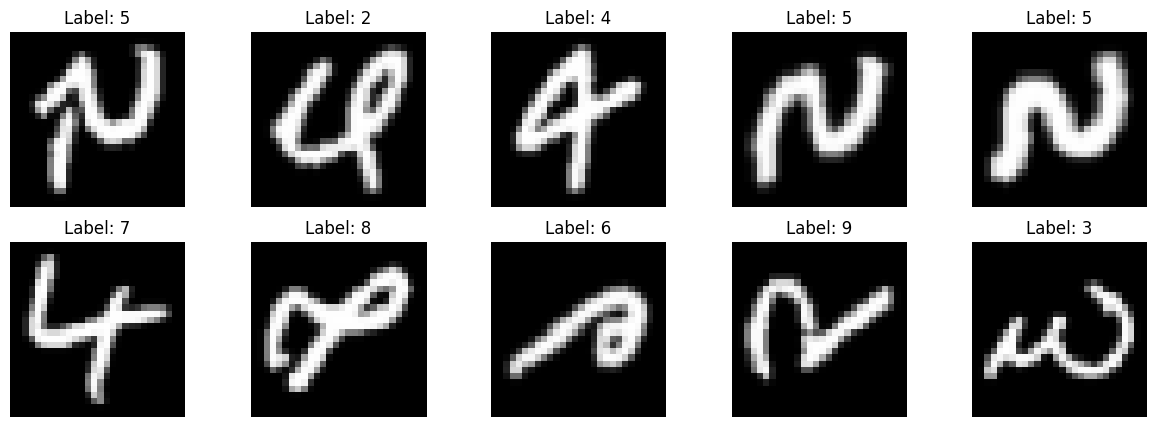

In [6]:
visualize_samples(data)

Prepare data

In [7]:

X = data.drop(columns='label').values.astype('float32') / 255.0  # Normalize pixel values
y = data['label'].values.astype('int64')

Split the data into training and testing sets

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create DataLoader

In [9]:

train_tensor = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_tensor = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [10]:
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=False)

Define the CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EMNIST_CNN(nn.Module):
    def __init__(self, input_shape=1, hidden_units=128, output_shape=10):
        super(EMNIST_CNN, self).__init__()
        
        # First convolutional block
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second convolutional block
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected classifier block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 7 * 7, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.classifier(x)
        return x


In [12]:
def plot_metrics(train_losses, test_losses, test_accuracies, optimizer_name):
    plt.figure(figsize=(15, 5))
    
   
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.title(f'Loss Curve ({optimizer_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy', color='green')
    plt.title(f'Accuracy Curve ({optimizer_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pred_vs_actual(actual, predicted, dataset_type):
    plt.figure(figsize=(12, 6))
    
  
    actual_counts = np.bincount(actual, minlength=10)
    predicted_counts = np.bincount(predicted, minlength=10)
    labels = np.arange(10)


    bar_width = 0.35

    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]

 
    plt.bar(r1, actual_counts, width=bar_width, color='blue', label='Actual', alpha=0.6)
    plt.bar(r2, predicted_counts, width=bar_width, color='orange', label='Predicted', alpha=0.6)


    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(f'Actual vs Predicted Labels ({dataset_type})')
    plt.xticks([r + bar_width / 2 for r in range(len(labels))], labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Function to train and evaluate the model

In [14]:
model = EMNIST_CNN()
def train_and_evaluate(optimizer_name):
    criterion = nn.CrossEntropyLoss()


    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    train_losses, test_losses, test_accuracies = [], [], []
    epochs = 3
    for epoch in range(epochs):
        model.train()
        running_loss, all_train_labels, all_train_preds = 0.0, [], []
        for images, labels in train_loader:
            images = images.view(-1, 1, 28, 28) 
            labels = labels
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_losses.append(running_loss / len(train_loader))

    
        model.eval()
        test_running_loss, all_test_labels, all_test_preds = 0.0, [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 1, 28, 28)
                labels = labels
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())

        test_losses.append(test_running_loss / len(test_loader))
        test_accuracies.append(accuracy_score(all_test_labels, all_test_preds))

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

    
    plot_metrics(train_losses, test_losses, test_accuracies, optimizer_name)


    plot_pred_vs_actual(all_train_labels, all_train_preds, "Training")
    plot_pred_vs_actual(all_test_labels, all_test_preds, "Testing")

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Training with Adam optimizer:
Epoch [1/3] - Train Loss: 0.1434, Test Loss: 0.0342, Test Accuracy: 0.9910
Epoch [2/3] - Train Loss: 0.0491, Test Loss: 0.0328, Test Accuracy: 0.9916
Epoch [3/3] - Train Loss: 0.0381, Test Loss: 0.0231, Test Accuracy: 0.9941


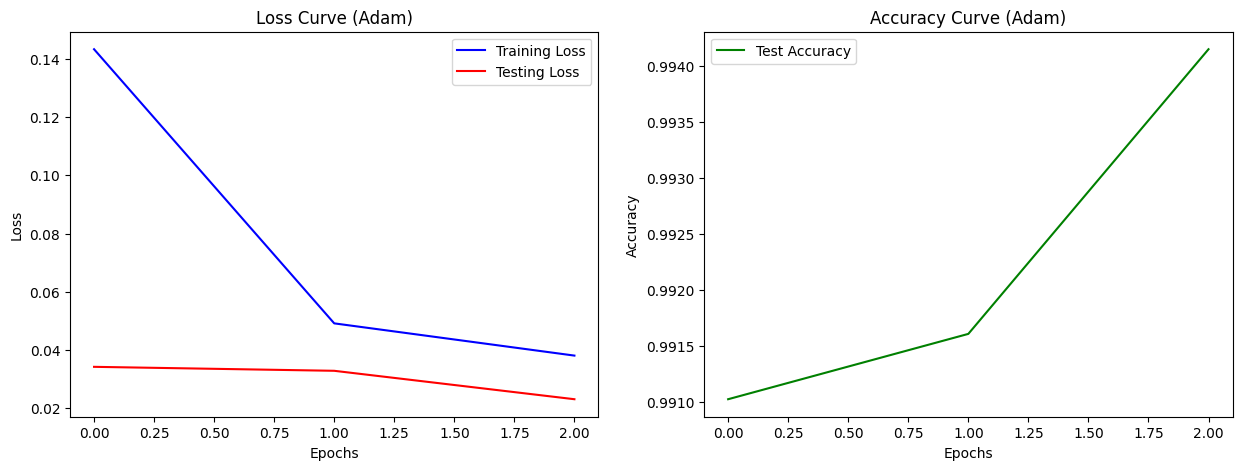

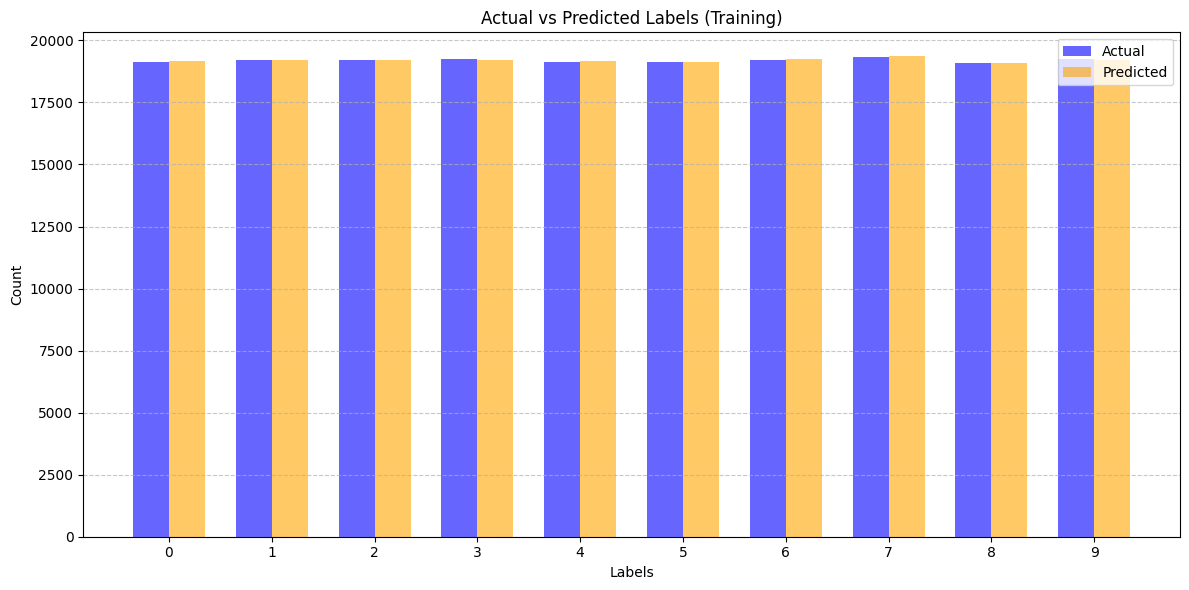

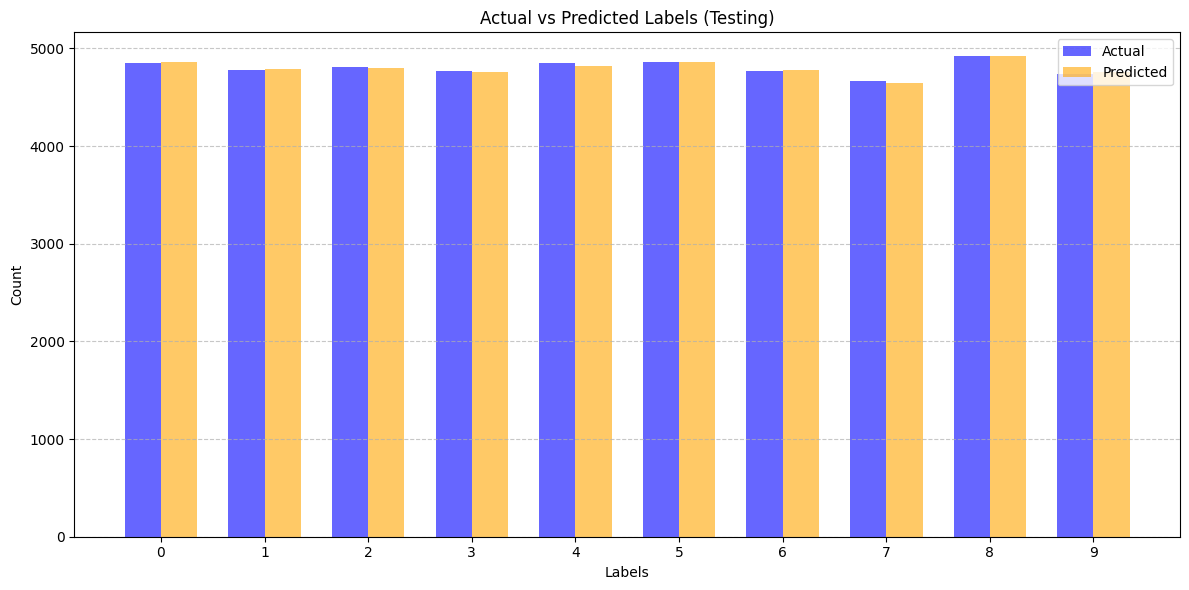

In [16]:
for opt in ["Adam"]:
    print(f"\nTraining with {opt} optimizer:")
    train_and_evaluate(opt)

In [17]:

model_path = "emnist_cnn_new_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to emnist_cnn_new_model.pth
